In [838]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob2

In [839]:
allocations = dict(
    NDX=528, # Nasdaq 100
    EM=335, # MSCI Emerging Markets
    ASI=177, # MSCI Emerging Asia
    R1000G=205, # Russell 1000 Growth 
    SP500=158 # S&P
)

In [840]:
# importing etf holdings data
df_ndx = pd.read_csv('ETF/NDX.csv', sep=';', header=3).rename(columns={'Weight (%)': 'Weight_NDX'})
df_r1000g = pd.read_csv('ETF/R1000G.csv', sep=';', header=7).rename(columns={'Weight (%)': 'Weight_R1000G'})
df_sp500 = pd.read_csv('ETF/SP500.csv', sep=';', header=7).rename(columns={'Weight (%)': 'Weight_SP500'})
df_em = pd.read_csv('ETF/EM.csv', sep=';', header=7).rename(columns={'Weight (%)': 'Weight_EM'})
df_asi = pd.read_csv('ETF/ASI.csv', sep=';', header=7).rename(columns={'Weight (%)': 'Weight_ASI'})

In [841]:
# merging all etf data
merge_col = ['Ticker', 'Name', 'Sector']

df = (df_r1000g
      .merge(df_ndx, on="ISIN", how='outer', suffixes=('','_y'))
      .merge(df_sp500, on=merge_col, how='outer', suffixes=('','_y'))
      .merge(df_em, on=merge_col, how='outer', suffixes=('','_y'))
      .merge(df_asi, on=merge_col, how='outer', suffixes=('','_y'))
     )

In [842]:
# Filtering and changing dtypes
df.Name = df.Name.astype(str)
df.loc[df.Name == 'nan', 'Name'] = df[df.Name == 'nan'].Name_y
df.loc[df.Name == 'nan', 'Sector'] = df[df.Name == 'nan'].Sector_y

df = df.loc[:,['Ticker', 'Name', 'Sector', 'Weight_NDX', 'Weight_R1000G', 'Weight_SP500', 'Weight_EM', 'Weight_ASI']]
df = df[df.Sector != 'Cash and/or Derivatives']

for col in df.loc[:, df.columns.str.contains('Weight_')].columns.tolist():
    df[col] = df[col].str.replace(',', '.').astype('float')
    df[col] = df[col].fillna(0)

In [843]:
# Sum of hodlings and weights
df['Total'] = 0
for col in df.loc[:, df.columns.str.contains('Weight')].columns.tolist():
    df['Total'] += allocations[col.strip('Weight_')] * df[col] / 100
    
df['Total_weight'] = df['Total'] / df['Total'].sum() * 100
df = df.sort_values(by='Total', ascending=False)

In [844]:
df[df.Total > 10]

,Ticker,Name,Sector,Weight_NDX,Weight_R1000G,Weight_SP500,Weight_EM,Weight_ASI,Total,Total_weight
1,AAPL,APPLE INC,Information Technology,11.84,8.76,5.58,0.00,0.00,89.2896,6.392531
0,MSFT,MICROSOFT CORP,Information Technology,11.40,8.91,5.64,0.00,0.00,87.3687,6.255008
2,AMZN,AMAZON COM INC,Consumer Discretionary,10.12,6.68,4.18,0.00,0.00,73.7320,5.278712
790,BABA,ALIBABA GROUP HOLDING ADR REPRESEN,Consumer Discretionary,0.00,0.00,0.00,7.05,8.48,38.6271,2.765439
3,FB,FACEBOOK CLASS A INC,Communication,4.39,3.43,2.17,0.00,0.00,33.6393,2.408346
791,700,TENCENT HOLDINGS LTD,Communication,0.00,0.00,0.00,5.63,6.72,30.7549,2.201843
5,GOOGL,ALPHABET INC CLASS A,Communication,3.88,2.65,1.67,0.00,0.00,28.5575,2.044524
4,GOOG,ALPHABET INC CLASS C,Communication,3.85,2.66,1.66,0.00,0.00,28.4038,2.033520
792,2330,TAIWAN SEMICONDUCTOR MANUFACTURING,Information Technology,0.00,0.00,0.00,4.52,5.25,24.4345,1.749345
793,005930,SAMSUNG ELECTRONICS LTD,Information Technology,0.00,0.00,0.00,3.57,4.15,19.3050,1.382107


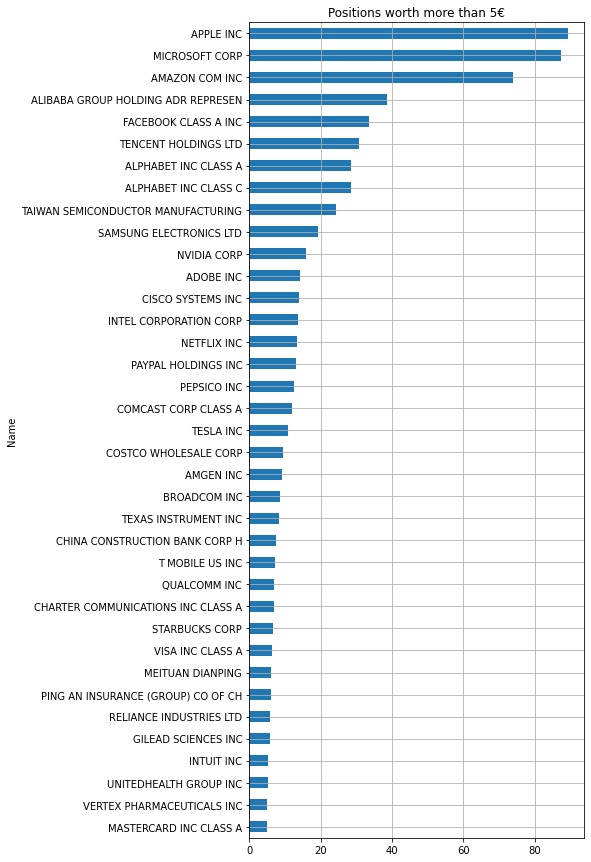

In [845]:
min_value = 5
(df[df.Total > min_value]
 .set_index('Name')
 .Total
 .sort_values(ascending=True)
 .plot(kind="barh", grid=True, figsize=(6,15), title=f'Positions worth more than {min_value}€')
)

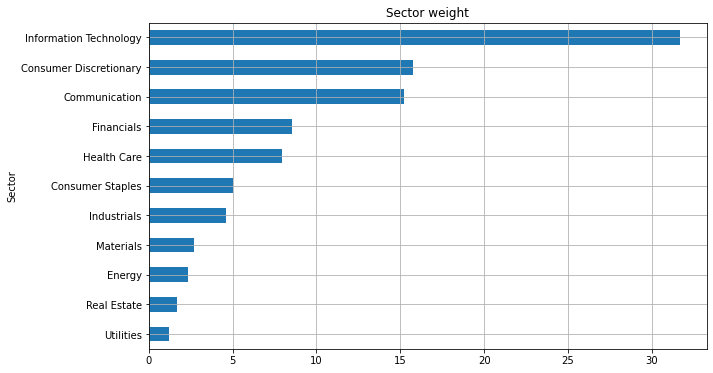

In [846]:
(df.groupby('Sector')
 .sum()
 .Total_weight
 .sort_values(ascending=True)
 .plot(kind='barh', grid=True, figsize=(10,6), title='Sector weight'))